# IFAC 2024 EEG signal features extraction for stress

## Libraries

In [1]:
import os
from pathlib import Path

# Define a base directory for the dataset
if 'google.colab' in str(get_ipython()):
    # Code is running in Google Colab
    from google.colab import drive
    drive.mount('/content/drive')
    base_dir = Path('/content/drive/My Drive/Supervised-Project/Data')
    !pip install matplotlib pandas numpy ts2vg scikit-image pyfeats scikit-learn==1.1.3 lazypredict dask
else:
    # Code is running locally
    base_dir = Path('Data/')  # Adjust to your local relative path


Mounted at /content/drive
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 54.2 MB/s eta 0:00:00
  Created wheel for pyfeats: filename=pyfeats-1.0.1-py3-none-any.whl size=49759 sha256=52e365dc095bbe893c2701feaeda2eee1fe96b7c07f8014f0b2be12a6600daf7
  Stored in directory: /root/.cache/pip/wheels/00/c9/c5/4d3a5cf39f7bb3bae26281c49868a4bd56f9dbbde8f919dce4
Successfully built pyfeats
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependen

In [2]:
# General use libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Visibility graph generation
from ts2vg import NaturalVG
from skimage import transform

# Features extraction
import pyfeats
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from lazypredict.Supervised import LazyClassifier


## Functions

In [3]:
def create_VG(sig_dt, w_n, it, limit_p):
    """
    Create a visibility graph from the given signal data.

    Parameters:
    sig_dt (array-like): The signal data.
    w_n (bool): Whether to use weighted edges.
    it (int): The size to which the adjacency matrix should be resized.
    limit_p (float): The penetrable limit for the visibility graph.

    Returns:
    np.ndarray: The resized adjacency matrix as an image.
    """
    sig_n = sig_dt

    nvg = NaturalVG(weighted=w_n, penetrable_limit=limit_p).build(sig_n)

    if w_n is None:
        adm = nvg.adjacency_matrix(triangle="both", use_weights=False)
    else:
        adm = nvg.adjacency_matrix(triangle="both", use_weights=True)

    nan_mask = np.isnan(adm)
    adm[nan_mask] = 0

    images = transform.resize(adm, (it, it), anti_aliasing=True)

    return images

def split_signal_into_windows(signal, window_size, overlap_percentage):
    """
    Splits the signal into overlapping windows.

    Parameters:
    signal (array-like): The input signal to be windowed.
    window_size (int): The size of each window.
    overlap_percentage (float): The percentage of overlap between consecutive windows.

    Returns:
    tuple: A tuple containing:
        - windows (list of array-like): A list of windows.
        - num_windows (int): The number of windows created.
    """
    overlap_size = int(window_size * overlap_percentage)
    windows = []

    for start in range(0, len(signal) - window_size + 1, window_size - overlap_size):
        window = signal[start:start + window_size]
        if len(window) == window_size:
            windows.append(window)

    num_windows = len(windows)
    return windows, num_windows

def VG_feat(wind, limit_p, weight, img_size):
    """
    Extracts various features from a visibility graph created from the given window of signal data.

    Parameters:
    wind (array-like): The window of signal data.
    limit_p (float): The penetrable limit for the visibility graph.
    weight (bool): Whether to use weighted edges in the visibility graph.
    img_size (int): The size to which the adjacency matrix should be resized.

    Returns:
    tuple: A tuple containing:
        - features (np.ndarray): The extracted features.
        - labels (list of str): The labels corresponding to the features.
    """
    # Create the visibility graph image
    img = create_VG(wind, w_n=weight, it=img_size, limit_p=limit_p)
    img[img > 0] = 1  # Binarize the image

    # Zernike moments features (Binarized)
    f1_zer = img
    mask = f1_zer.copy()
    mask[mask > 0] = 1

    # Zernike moments features (Non-Binarized)
    f3_zer = img
    features_z, labels_z = pyfeats.zernikes_moments(f3_zer, radius=9)

    # Hu's moments features
    f1_hu = img
    features_hu, labels_hu = pyfeats.hu_moments(f1_hu)

    # Wavelet Packet (WP) moments features
    f1_wp = img
    features_wp, labels_wp = pyfeats.wp_features(f1_wp, mask, maxlevel=3)

    # SCSA features (commented out)
    # f1_scsa = img
    # features_scsa = SCSA2D_fet(f1_scsa, img_size)
    labels_scsa = ['K1sq_sum', 'K2sq_sum', 'K3sq_sum', 'K1r_sum', 'K1m_sum', 'N_sum', 'mean_sums', 'std_sums',
                   'INV1_sums', 'INV2_sums', 'INV3_sums', 'First_sums']

    # Combine all features and labels
    features = np.hstack((features_z.reshape(1, -1), features_hu.reshape(1, -1), features_wp.reshape(1, -1))).reshape(1, -1)
    labels = np.hstack((np.asarray(labels_z).reshape(1, -1), np.asarray(labels_hu).reshape(1, -1), np.asarray(labels_wp).reshape(1, -1))).reshape(-1,)

    return features, list(labels)




def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model
        to generalize and improves the interpretability of the model.

    Inputs:
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output:
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)
    print('Removed Columns {}'.format(drops))
    return x

## Load EEG signal data

In [4]:
signal=np.load(f"{base_dir}/eeg_signals.npy",allow_pickle=True).item()

In [5]:
patients = list(signal.keys())
patients.remove('2105_1')
print(patients)

['2107_1', '2126_1', '2104_2', '2123_1', '2124_2', '2113_1', '2122_1', '2110_1', '2121_1', '2104_1', '2114_1', '2131_2', '2120_1', '2112_1', '2115_1', '2117_1', '2119_1', '2130_1', '2131_1', '2109_1', '2129_1', '2116_1', '2134_1', '2133_1', '2111_1', '2108_1', '2132_1', '2127_1', '2106_1', '2124_1', '2125_1', '2136_1']


## Create Visibility Graph and extract features

In [6]:
# Windowing parameters
window_size = 100  # Size of each window in samples
overlap_percentage = 0  # Percentage of overlap between consecutive windows

# Visibility graph parameters
limit_p = 0  # Penetrable limit for the visibility graph
img_size = 10  # Size to which the adjacency matrix should be resized

# Sampling rates
original_rate = 250  # Original sample rate of the EEG signal (Hz)
new_rate = 10  # New sample rate after downsampling (Hz)

Processes EEG signals for each patients and extracts features

In [7]:
pac_vt_EEG = {}  # Dictionary to store the feature vectors for each patient

for pa in patients:
    if not signal[pa][0]:   # Check if the patient is empty
        print(f"Patient {pa} is empty.")
    else:
        print(f"Patient {pa} is correct. Will be added to the database.")

        status = list(signal[pa][0].keys())  # List of status for each patient

        for sta in status:
            bands = list(signal[pa][0][sta][0].keys())
            fet_ban = []  # List to store feature vectors for each band
            lab_ban = []  # List to store labels for each band

            for band in bands:
                fet_chn_ban = []  # List to store feature vectors for each channel and band
                lab_chn_ban = []  # List to store labels for each channel and band

                for chn in range(4):
                    sig_pa = np.array(signal[pa][0][sta][0][band][0][:, chn]).reshape(-1,)  # Extract the EEG signal for the given patient, status, band, and channel

                    windows, windo_num = split_signal_into_windows(sig_pa, window_size, overlap_percentage)
                    values_dt = []

                    # Extract features for each window
                    for wind in windows:
                        fet, lab = VG_feat(wind, limit_p, None, img_size)
                        lab = [s + "non" + band + str(chn) for s in lab]
                        lab_chn_ban.append(lab)  # Append labels for each channel
                        values_dt.append(fet.copy().reshape(-1,))

                    mean_ft = np.mean(np.asarray(values_dt), axis=0)  # Calculate the mean feature vector for each channel
                    fet_chn_ban.append(mean_ft.reshape(-1, 1))  # Append mean feature vectors for each channel

                fet_ban.append(np.concatenate(fet_chn_ban, axis=0))  # Concatenate feature vectors for each band
                lab_ban.append(np.concatenate(lab_chn_ban, axis=0))  # Concatenate labels for each band

            fts = np.asarray(fet_ban).flatten()
            lbs = np.asarray(lab_ban).flatten()
            dt_mean = np.hstack((fts, sta))
            pac_vt_EEG[f"{pa}_{sta}"] = [np.asarray(dt_mean)]  # Store the feature vectors for each patient and status


Patient 2107_1 is correct. Will be added to the database.
Patient 2126_1 is correct. Will be added to the database.
Patient 2104_2 is correct. Will be added to the database.
Patient 2123_1 is correct. Will be added to the database.
Patient 2124_2 is correct. Will be added to the database.
Patient 2113_1 is correct. Will be added to the database.
Patient 2122_1 is correct. Will be added to the database.
Patient 2110_1 is correct. Will be added to the database.
Patient 2121_1 is correct. Will be added to the database.
Patient 2104_1 is empty.
Patient 2114_1 is correct. Will be added to the database.
Patient 2131_2 is correct. Will be added to the database.
Patient 2120_1 is correct. Will be added to the database.
Patient 2112_1 is correct. Will be added to the database.
Patient 2115_1 is correct. Will be added to the database.
Patient 2117_1 is correct. Will be added to the database.
Patient 2119_1 is correct. Will be added to the database.
Patient 2130_1 is correct. Will be added to the

Create DataFrame for the extraxed features

In [8]:
# Convert the dictionary of feature vectors into a DataFrame
features_EEG = pd.DataFrame({key: pd.Series(value[0]) for key, value in pac_vt_EEG.items()})

# Transpose the DataFrame to have patients as rows and features as columns
features_EEG = features_EEG.T

# Set the column names of the DataFrame to the feature labels and add a "Labels" column
features_EEG.columns = np.hstack((lbs, "Labels"))

# Display the first few rows of the DataFrame
features_EEG.head()

,Zernikes_Moments_radius_9_0nonTheta0,Zernikes_Moments_radius_9_1nonTheta0,Zernikes_Moments_radius_9_2nonTheta0,Zernikes_Moments_radius_9_3nonTheta0,Zernikes_Moments_radius_9_4nonTheta0,Zernikes_Moments_radius_9_5nonTheta0,Zernikes_Moments_radius_9_6nonTheta0,Zernikes_Moments_radius_9_7nonTheta0,Zernikes_Moments_radius_9_8nonTheta0,Zernikes_Moments_radius_9_9nonTheta0,...,Hu_Moment_4nonGamma3,Hu_Moment_5nonGamma3,Hu_Moment_6nonGamma3,WP_coif1_h_meannonGamma3,WP_coif1_h_stdnonGamma3,WP_coif1_v_meannonGamma3,WP_coif1_v_stdnonGamma3,WP_coif1_d_meannonGamma3,WP_coif1_d_stdnonGamma3,Labels
2107_1_10,0.3183098861837902,4.005110789274865e-17,0.5979044409890316,0.029182044892478297,0.007643797182567578,0.015904248215856343,0.2765602759303996,0.06628376606286916,0.03350950904182252,0.017090997880744595,...,5.319752513745122e-11,8.029156823520376e-08,0.0,0.13262596499403445,0.24506804433036736,0.13262596499403445,0.2450680443303674,0.02262029781032965,0.058479624120974835,10
2107_1_20,0.3183098861837902,4.005110789274865e-17,0.5979044409890316,0.029182044892478297,0.007643797182567578,0.015904248215856343,0.2765602759303996,0.06628376606286916,0.03350950904182252,0.017090997880744595,...,5.319752513745122e-11,8.029156823520376e-08,0.0,0.13262596499403445,0.24506804433036736,0.13262596499403445,0.2450680443303674,0.02262029781032965,0.058479624120974835,20
2107_1_16,0.3183098861837902,4.005110789274865e-17,0.5979044409890316,0.029182044892478297,0.007643797182567578,0.015904248215856343,0.2765602759303996,0.06628376606286916,0.03350950904182252,0.017090997880744595,...,5.319752513745122e-11,8.029156823520376e-08,0.0,0.13262596499403445,0.24506804433036736,0.13262596499403445,0.2450680443303674,0.02262029781032965,0.058479624120974835,16
2107_1_26,0.3183098861837902,4.005110789274865e-17,0.5979044409890316,0.029182044892478297,0.007643797182567578,0.015904248215856343,0.2765602759303996,0.06628376606286916,0.03350950904182252,0.017090997880744595,...,5.319752513745122e-11,8.029156823520376e-08,0.0,0.13262596499403445,0.24506804433036736,0.13262596499403445,0.2450680443303674,0.02262029781032965,0.058479624120974835,26
2107_1_10_1,0.3183098861837902,4.005110789274865e-17,0.5979044409890316,0.029182044892478297,0.007643797182567578,0.015904248215856343,0.2765602759303996,0.06628376606286916,0.03350950904182252,0.017090997880744595,...,5.319752513745122e-11,8.029156823520376e-08,0.0,0.13262596499403445,0.24506804433036736,0.13262596499403445,0.2450680443303674,0.02262029781032965,0.058479624120974835,10_1


In [9]:
features=features_EEG.dropna()  # Remove rows with missing values
features.head()

,Zernikes_Moments_radius_9_0nonTheta0,Zernikes_Moments_radius_9_1nonTheta0,Zernikes_Moments_radius_9_2nonTheta0,Zernikes_Moments_radius_9_3nonTheta0,Zernikes_Moments_radius_9_4nonTheta0,Zernikes_Moments_radius_9_5nonTheta0,Zernikes_Moments_radius_9_6nonTheta0,Zernikes_Moments_radius_9_7nonTheta0,Zernikes_Moments_radius_9_8nonTheta0,Zernikes_Moments_radius_9_9nonTheta0,...,Hu_Moment_4nonGamma3,Hu_Moment_5nonGamma3,Hu_Moment_6nonGamma3,WP_coif1_h_meannonGamma3,WP_coif1_h_stdnonGamma3,WP_coif1_v_meannonGamma3,WP_coif1_v_stdnonGamma3,WP_coif1_d_meannonGamma3,WP_coif1_d_stdnonGamma3,Labels
2107_1_10,0.3183098861837902,4.005110789274865e-17,0.5979044409890316,0.029182044892478297,0.007643797182567578,0.015904248215856343,0.2765602759303996,0.06628376606286916,0.03350950904182252,0.017090997880744595,...,5.319752513745122e-11,8.029156823520376e-08,0.0,0.13262596499403445,0.24506804433036736,0.13262596499403445,0.2450680443303674,0.02262029781032965,0.058479624120974835,10
2107_1_20,0.3183098861837902,4.005110789274865e-17,0.5979044409890316,0.029182044892478297,0.007643797182567578,0.015904248215856343,0.2765602759303996,0.06628376606286916,0.03350950904182252,0.017090997880744595,...,5.319752513745122e-11,8.029156823520376e-08,0.0,0.13262596499403445,0.24506804433036736,0.13262596499403445,0.2450680443303674,0.02262029781032965,0.058479624120974835,20
2107_1_16,0.3183098861837902,4.005110789274865e-17,0.5979044409890316,0.029182044892478297,0.007643797182567578,0.015904248215856343,0.2765602759303996,0.06628376606286916,0.03350950904182252,0.017090997880744595,...,5.319752513745122e-11,8.029156823520376e-08,0.0,0.13262596499403445,0.24506804433036736,0.13262596499403445,0.2450680443303674,0.02262029781032965,0.058479624120974835,16
2107_1_26,0.3183098861837902,4.005110789274865e-17,0.5979044409890316,0.029182044892478297,0.007643797182567578,0.015904248215856343,0.2765602759303996,0.06628376606286916,0.03350950904182252,0.017090997880744595,...,5.319752513745122e-11,8.029156823520376e-08,0.0,0.13262596499403445,0.24506804433036736,0.13262596499403445,0.2450680443303674,0.02262029781032965,0.058479624120974835,26
2107_1_10_1,0.3183098861837902,4.005110789274865e-17,0.5979044409890316,0.029182044892478297,0.007643797182567578,0.015904248215856343,0.2765602759303996,0.06628376606286916,0.03350950904182252,0.017090997880744595,...,5.319752513745122e-11,8.029156823520376e-08,0.0,0.13262596499403445,0.24506804433036736,0.13262596499403445,0.2450680443303674,0.02262029781032965,0.058479624120974835,10_1


Save the feature vectors to a CSV file

In [10]:
features.to_csv('EEG_features_100')  # Save the feature vectors to a CSV file

In [11]:
features_num=features.iloc[:,0:-1]
features_num= features_num.astype(float)

## Preprocess features

In [12]:
nan_columns = features_num.columns[features_num.isna().any()].tolist()  # Find columns with NaN values

print("Columns with NaN values:")
print(nan_columns)

Columns with NaN values:
[]


In [13]:
nan_rows = features_num[features_num.isna().any(axis=1)]  # Find rows with NaN values

print("Rows with NaN values:")
print(nan_rows)

Rows with NaN values:
Empty DataFrame
Columns: [Zernikes_Moments_radius_9_0nonTheta0, Zernikes_Moments_radius_9_1nonTheta0, Zernikes_Moments_radius_9_2nonTheta0, Zernikes_Moments_radius_9_3nonTheta0, Zernikes_Moments_radius_9_4nonTheta0, Zernikes_Moments_radius_9_5nonTheta0, Zernikes_Moments_radius_9_6nonTheta0, Zernikes_Moments_radius_9_7nonTheta0, Zernikes_Moments_radius_9_8nonTheta0, Zernikes_Moments_radius_9_9nonTheta0, Zernikes_Moments_radius_9_10nonTheta0, Zernikes_Moments_radius_9_11nonTheta0, Zernikes_Moments_radius_9_12nonTheta0, Zernikes_Moments_radius_9_13nonTheta0, Zernikes_Moments_radius_9_14nonTheta0, Zernikes_Moments_radius_9_15nonTheta0, Zernikes_Moments_radius_9_16nonTheta0, Zernikes_Moments_radius_9_17nonTheta0, Zernikes_Moments_radius_9_18nonTheta0, Zernikes_Moments_radius_9_19nonTheta0, Zernikes_Moments_radius_9_20nonTheta0, Zernikes_Moments_radius_9_21nonTheta0, Zernikes_Moments_radius_9_22nonTheta0, Zernikes_Moments_radius_9_23nonTheta0, Zernikes_Moments_radius_9_

Remove Collinear features

In [14]:
# Compute correlation matrix

df_filtered = remove_collinear_features(features_num,0.6)

Removed Columns {'Zernikes_Moments_radius_9_17nonTheta1', 'Zernikes_Moments_radius_9_21nonTheta3', 'Hu_Moment_1nonAlpha_low1', 'Zernikes_Moments_radius_9_16nonAlpha_high3', 'WP_coif1_h_stdnonBeta2', 'Zernikes_Moments_radius_9_21nonBeta0', 'Zernikes_Moments_radius_9_24nonBeta0', 'Zernikes_Moments_radius_9_6nonAlpha_high2', 'Zernikes_Moments_radius_9_6nonAlpha_high1', 'Hu_Moment_4nonTheta1', 'Hu_Moment_5nonGamma3', 'Zernikes_Moments_radius_9_13nonAlpha_high2', 'Zernikes_Moments_radius_9_10nonBeta1', 'Zernikes_Moments_radius_9_8nonTheta3', 'Hu_Moment_1nonGamma1', 'Zernikes_Moments_radius_9_0nonTheta3', 'Hu_Moment_2nonTheta3', 'Hu_Moment_3nonTheta3', 'WP_coif1_d_stdnonGamma0', 'Zernikes_Moments_radius_9_23nonTheta0', 'Hu_Moment_5nonAlpha_low2', 'WP_coif1_h_stdnonAlpha_low3', 'Zernikes_Moments_radius_9_15nonGamma0', 'Zernikes_Moments_radius_9_24nonGamma2', 'Zernikes_Moments_radius_9_17nonBeta1', 'Zernikes_Moments_radius_9_12nonBeta2', 'WP_coif1_v_meannonBeta0', 'Hu_Moment_4nonBeta1', 'WP_co

## K-Means Clustering

Standardise features

In [15]:
data = df_filtered.values
scaler = StandardScaler()
data = scaler.fit_transform(data)

In [16]:
df_filtered.shape

(666, 84)

In [17]:
n_clusters = 2

kmeans = KMeans(n_clusters=n_clusters, random_state=0)  # Assuming 2 clusters
kmeans.fit(data)

# Get cluster centers and labels
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_



## PCA Visualization of Clusters

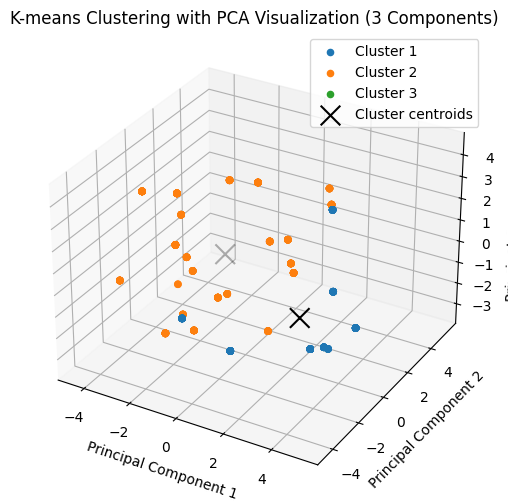

In [18]:
n_components = 3
# Visualize the clustered data using PCA for dimensionality reduction
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(data)


# Plotting the clustered data
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the data points with different colors for each cluster
for i in range(n_components):
    ax.scatter(X_pca[kmeans.labels_ == i, 0], X_pca[kmeans.labels_ == i, 1], X_pca[kmeans.labels_ == i, 2], label=f'Cluster {i+1}')

# Plotting the centroids of the clusters
centroids_pca = pca.transform(kmeans.cluster_centers_)
ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], centroids_pca[:, 2], marker='x', s=200, c='black', label='Cluster centroids')

# Adding labels and title
ax.set_title(f'K-means Clustering with PCA Visualization ({n_components} Components)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.grid(True)
plt.show()


## Train-Test Split

In [19]:
df_filtered['target']=features['Labels']  # Add the target column to the DataFrame
df_filtered= df_filtered[~df_filtered.index.str.contains('20|10')]  # Remove the rows with the target values "20" and "10"

unique_patients = df_filtered.index.unique()

train_patients, test_patients = train_test_split(unique_patients, test_size=0.3, random_state=42)

train_data = []
test_data = []

# Split the data into training and testing sets
for patient_id in train_patients:
    patient_data = df_filtered.loc[patient_id,:]
    train_data.append(patient_data)

for patient_id in test_patients:
    patient_data = df_filtered.loc[patient_id,:]
    test_data.append(patient_data)

# Convert the training and testing data to DataFrames
train_data_df=pd.DataFrame(train_data)
test_data_df=pd.DataFrame(test_data)


X_train = train_data_df.drop(columns=['target'])  # Only features
y_train = train_data_df['target']  # Only target

X_test = test_data_df.drop(columns=['target'])
y_test = test_data_df['target']

In [20]:
y_train.head()

,target
2124_2_23,23
2119_1_24,24
2117_1_16,16
2133_1_22,22
2126_1_24,24


## Label Transformation

In [21]:
def change_labels(labels):
    new_labels = []
    for label in labels:
        label = int(label)
        if label < 14:
            new_labels.append(0)
        else:
            new_labels.append(1)
    return new_labels

y_train = change_labels(y_train)

y_test = change_labels(y_test)

## Feature Selection

In [22]:
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

selec=SelectKBest(f_classif, k=20)

X_train_sel= selec.fit_transform(X_train, y_train)
X_test_sel= selec.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [ 6 11 18 21 25 32 38 43 44 47 51 52 56 62 68 70 74 76 80 83] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


## Model Training and Evaluation

In [23]:
# Fit all models
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train_sel, X_test_sel, y_train, y_test)
models

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
100%|██████████| 29/29 [00:01<00:00, 26.44it/s]

[LightGBM] [Info] Number of positive: 125, number of negative: 43
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 277
[LightGBM] [Info] Number of data points in the train set: 168, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.744048 -> initscore=1.067114
[LightGBM] [Info] Start training from score 1.067114
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SGDClassifier,0.67,0.58,0.58,0.66,0.02
PassiveAggressiveClassifier,0.62,0.52,0.52,0.60,0.01
NuSVC,0.68,0.50,0.50,0.59,0.02
LinearSVC,0.70,0.50,0.50,0.57,0.03
XGBClassifier,0.70,0.50,0.50,0.57,0.10
SVC,0.70,0.50,0.50,0.57,0.01
RidgeClassifierCV,0.70,0.50,0.50,0.57,0.02
RidgeClassifier,0.70,0.50,0.50,0.57,0.02
Perceptron,0.70,0.50,0.50,0.57,0.01
